# drosophila_simulation_experimentation-2

> More experimentation with the germ band simulations

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [ ]:
## import stuff

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm
import CE_simulation.phase_analysis as ana

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from scipy import ndimage, spatial

from collections import Counter, defaultdict
import itertools

from copy import deepcopy
import os
import sys
import pickle
import time as time_module

from joblib import Parallel, delayed

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs);
importlib.reload(dis); importlib.reload(hes); importlib.reload(ecm); importlib.reload(ana);

In [ ]:
## analysis functions

def get_width_height(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta

In [ ]:
meshes_dict = {}
property_dict_dict = {}
elongation_dict = {}
last_flip_dict = {}

### Defining simulation

In [ ]:
## set fixed simulation parameters

timeout_iteration = 20*60 

# initial condition parameters
n_x = 23 # 24
n_y = 34 # 34

noise_gaussian = 0.1
initial_strain = 0.2
initial_strain = np.sqrt(1+initial_strain)-1
isogonal = 0
orientation = "cable"

# triangulation dynamics parameters
m = 4
k = 6
k_cutoff = 0.3
k_relax = 2

# elastic energy parameters
mod_bulk = 1
mod_shear = 1
angle_penalty = 1000
bdry_penalty = 5000 # 5000

# numerical parameters
dt = .005 # time step
forbid_reflip = 20
tri_mod_area = .01 # triangle area regularization
minimal_l = 0.06
tol, maxiter = (1e-4, 50000) # 100000. 10k too low, but has runtime of approx 10s. try 50k
epsilon_l = (1e-3, 1e-3)  # mollifying parameters to ensure energy differentiability
bdr_weight = 1 # avoid problems at boundary. 4

# elastic energy patterning
rel_bulk_modulus = -10 #0.8 # reduction in bulk modulus in passive cells
rel_shear_modulus = -10 #0.99 # reduction in shear modulus in passive cells
#rel_angle_penalty = 0.995

def rhs_rest_shape(v): # no rest shape relaxation, since we have no passive cells
    return 0

# package all into a single dict to pass to the optimizer method
energy_args = {'mod_bulk': mod_bulk, 'mod_shear': mod_shear,
               'angle_penalty': angle_penalty, 'bdry_penalty': bdry_penalty, 'epsilon_l': epsilon_l,
               'mod_area': 0, 'mod_perimeter': 0}
optimizer_args = {'energy_args': energy_args, 'tol': tol, 'maxiter': maxiter, 'verbose': True,
                  'bdr_weight': bdr_weight}

In [ ]:
6* 0.75

4.5

In [ ]:
### Definining initial cond geometry

In [ ]:
mesh_initial, property_dict = drs.create_rect_initial(n_x, n_y, noise=noise_gaussian, initial_strain=initial_strain,
                                                      orientation='orthogonal', isogonal=isogonal, random_seed=3,
                                                      boundaries=['top', 'bottom',], w_passive=.5, w_passive_lr=.5)

#mesh_initial.optimize_cell_shape(**optimizer_args,)

edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_colors = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
               for key in mesh_initial.vertices.keys() if not key in property_dict['passive_cells']}


In [ ]:
def get_top_bottom_bdry_edges(mesh):
    bdry_cells = mesh.bdry_list[0][1]+mesh.bdry_list[1][1]
    edge_lst = []
    for key, he in mesh.hes.items():
        if any([v.is_bdry() for v in he.vertices]):
            if he.face is None:
                is_top_bottom = any([v._vid in bdry_cells for v in he.twin.face.vertices])
            else:
                is_top_bottom = any([v._vid in bdry_cells for v in he.face.vertices])
            if is_top_bottom:
                edge_lst.append(he._heid)
    return edge_lst

In [ ]:
edge_colors_tri = {}
top_bottom_bdry_edges = get_top_bottom_bdry_edges(mesh_initial)
for key, he in mesh_initial.hes.items():
    if not key in top_bottom_bdry_edges:
        if key in property_dict['passive_edges'] or he.is_bdry():
            edge_colors_tri[key] = np.array([0.8, 0.2, 0, .2]) 
        else:
            edge_colors_tri[key] = np.array([0.8, 0.2, 0, 1])
    else:
        #edge_colors_tri[key] = np.array([0, 0, 0, 1])
        edge_colors_tri[key] = np.array([0.8, 0.2, 0, .2]) 

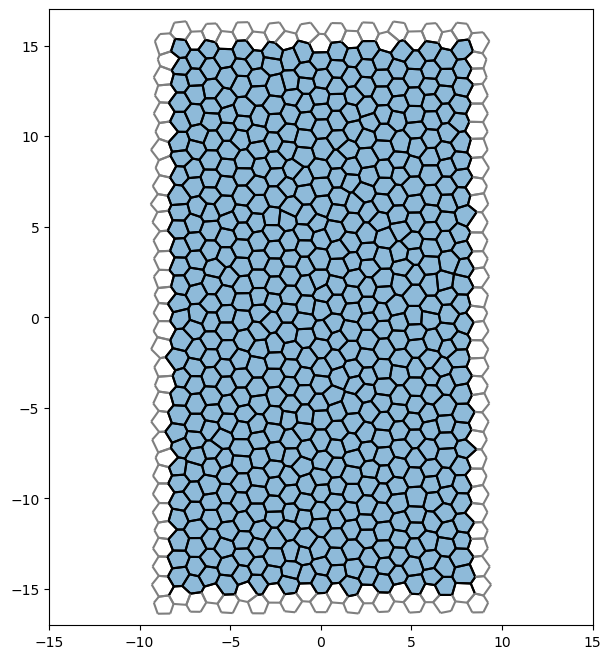

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot_color(edge_colors=edge_colors_tri)

#for v in bdry_cells:
#    plt.scatter(*mesh_initial.vertices[v].coords, c="tab:orange")
    #plt.scatter(*mesh_initial.vertices[v].get_centroid(), c="k")

bdry_x, bdry_y = (15, 17)
ax = plt.gca()
ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

In [ ]:
## define local function for simulation

timeout_iteration = 120

def run_phase_diagm_sim(w_passive, rel_angle_penalty, n_steps, random_seed=None, verbose=False):
    """
    Local function to run simulation in parallel.
    
    run_id can be used to additionally label the folder for saving, in case multiple simulations are run
    for the same parameter values.
    """    
    # set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    # create initial condition
    mesh_initial, property_dict = drs.create_rect_initial(n_x, n_y, noise=noise_gaussian, initial_strain=initial_strain,
                                                          orientation='orthogonal', isogonal=isogonal, random_seed=random_seed,
                                                          boundaries=['top', 'bottom',], w_passive=w_passive, w_passive_lr=0.5)
    
    # set passive tensions in passive region
    for e in property_dict['passive_edges']:
        mesh_initial.hes[e].passive = mesh_initial.hes[e].rest
        mesh_initial.hes[e].twin.passive = mesh_initial.hes[e].twin.rest

    # patterning of triangulation dynamics
    def params_pattern(fid):
        if fid in property_dict['passive_faces']:
            return {"m": None, "k_cutoff": None, "k": k, "is_active": False, "subtract_passive": False} 
        return {"m": m, "k_cutoff": k_cutoff, "k": k, "is_active": True, "subtract_passive": False}
        
    # for bdry condition
    top_bottom_bdry_edges = get_top_bottom_bdry_edges(mesh_initial)
        
    # patterning of mechanics
    cell_id_to_modulus = defaultdict(lambda: (lambda x: 1))
    cell_id_to_modulus["mod_bulk"] = lambda x: 1-rel_bulk_modulus*(x in property_dict['passive_cells'])
    cell_id_to_modulus["mod_shear"] = lambda x: 1-rel_shear_modulus*(x in property_dict['passive_cells'])
    # also reduce the angle penalty proportionally in the passive region
    edge_id_to_angle_penalty = lambda x: 1-rel_angle_penalty*(x in property_dict['passive_edges'])
    optimizer_args['cell_id_to_modulus'] = cell_id_to_modulus
    optimizer_args['edge_id_to_angle_penalty'] = edge_id_to_angle_penalty

    # main simulation loop
    times = [0]; last_flipped_edges = [[]]
    mesh = mesh_initial
    mesh_previous = deepcopy(mesh)
    meshes = [mesh_previous]

    if verbose:
        pbar = tqdm(range(n_steps-1))
        pbar.set_description(f"Runnig simulation")
    else:
        pbar = range(n_steps-1)
    for i in pbar:
        current_time = time_module.time()
        # euler step
        mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass_new, params=params_pattern, # excitable_dt_act_pass_new_passive_rest
                        rhs_rest_shape=rhs_rest_shape)
        # flatten triangulation.
        sol = mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4, return_sol=True, reset_intrinsic=False,
                                         soften_direct=0, soften_indirect=0)
        # cancel execution if this fails. precision loss and insufficient iteration errors are typically harmless.
        if sol["status"] !=0 and (sol["message"] == "NaN result encountered."):
            print("Triangulation optimization failed")
            break
        # relax intrinsic lengths
        if k_relax < np.infty:
            mesh.euler_step_relax(k_relax=k_relax/dt, dt=dt)
        else:
            mesh.set_rest_lengths()
        # primal optimization
        sol = mesh.optimize_cell_shape(**optimizer_args, return_sol=True)
        if sol["status"] !=0 and (sol["message"] == "NaN result encountered."):
            print("Cell optimization failed")
            break
        # check for intercalation
        flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                                minimal_l=minimal_l, reoptimize=False,
                                                optimizer_args=optimizer_args)
        # set passive tension on passive edges
        for e in flipped:
            if e in property_dict['passive_edges']:
                mesh.hes[e].passive = np.random.normal(loc=1, scale=0.15)
                mesh.hes[e].twin.passive = np.random.normal(loc=1, scale=0.15)

        # rescale & reorient triangulation
        mesh.transform_vertices(dln.get_conformal_transform(mesh_previous, mesh))
        # log & save
        last_flipped_edges.append(flipped)
        times.append(times[-1]+dt)
        mesh_previous = deepcopy(mesh)
        meshes.append(mesh_previous)
        # time out
        if (time_module.time()-current_time) > timeout_iteration:
            break
    # make measurements
    last_flipped_edges.append([])
    # measure elongation
    
    delta_series = [get_width_height(m, q=0.8, exclude=property_dict['passive_cells']) for m in meshes]
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series), axis=0, sigma=2)
    delta_series = np.log(delta_series/delta_series[1])
    elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)
    
    return meshes, property_dict, elongation, last_flipped_edges


In [ ]:
### Runnning simulation

In [ ]:
# increase the cutoff for t1s to 0.075 ?

In [ ]:
## test run

n_steps = 125 # 240 = 30 mins.

# Setting angle penalty yo 0 in top/bottom bdry is bad - get bowties immidiately. 0.995 is also bad - slow, eventually develop flips/
# now trying angle penalty = 1 on bdr cells. Let's just not mess with these smaller simulations. no point.


single_sim_results = run_phase_diagm_sim(w_passive=.5, rel_angle_penalty=0.995, n_steps=n_steps, random_seed=1, verbose=True)

# try a toll rm9 like sim. best if boundary is really small, and not softened

  0%|          | 0/124 [00:00<?, ?it/s]

In [ ]:
to_do = [(5, 0.995, 1)]

for key, data in zip(to_do, [single_sim_results, ]):
    meshes, property_dict, elongation, last_flipped_edges = data

    meshes_dict[key] = meshes
    property_dict_dict[key] = property_dict
    elongation_dict[key] = elongation
    last_flip_dict[key] = last_flipped_edges

In [ ]:
## define simulation sweep

w_passives = [6, 7, 8]
rel_angle_penalties = [0.99, 0.995, 0.999]
reps = [1, 2, 3]

to_do = list(itertools.product(w_passives, rel_angle_penalties, reps))
len(to_do)

27

In [ ]:
25*0.005*280

35.0

In [ ]:
## run simulation

n_steps = 280 #280

joblib_results = Parallel(n_jobs=len(to_do))(delayed(run_phase_diagm_sim)(w_passive, rel_angle_penalty, n_steps=n_steps, random_seed=rep, verbose=False)
    for w_passive, rel_angle_penalty, rep in to_do)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and

In [ ]:
## unpack simulation and compute averages over realizations

for key, data in zip(to_do, joblib_results):
    meshes, property_dict, elongation, last_flipped_edges = data

    meshes_dict[key] = meshes
    property_dict_dict[key] = property_dict
    elongation_dict[key] = elongation
    last_flip_dict[key] = last_flipped_edges

In [ ]:
{key: len(val) for key, val in meshes_dict.items()}

In [ ]:
n_steps = 280
time = np.arange(n_steps) * dt * 25

### Snapshots

In [ ]:
meshes_dict.keys()

dict_keys([(5, 0.995, 1)])

In [ ]:
bdry_x, bdry_y = (18, 18)

w_passive = 5
rel_angle_penalty = 0.995
rep = 1

key = (w_passive, rel_angle_penalty, rep)

meshes = meshes_dict[key]
edge_colors = {e: "tab:grey" for e in property_dict_dict[key]['passive_edges']}
cell_colors = {v: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
               for v in meshes[1].vertices.keys() if not v in property_dict_dict[key]['passive_cells']}
edge_colors_tri = {e: np.array([0.8, 0.2, 0, .2]) if e in property_dict_dict[key]['passive_edges']
                   or any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                   for e, he in meshes[0].hes.items()}


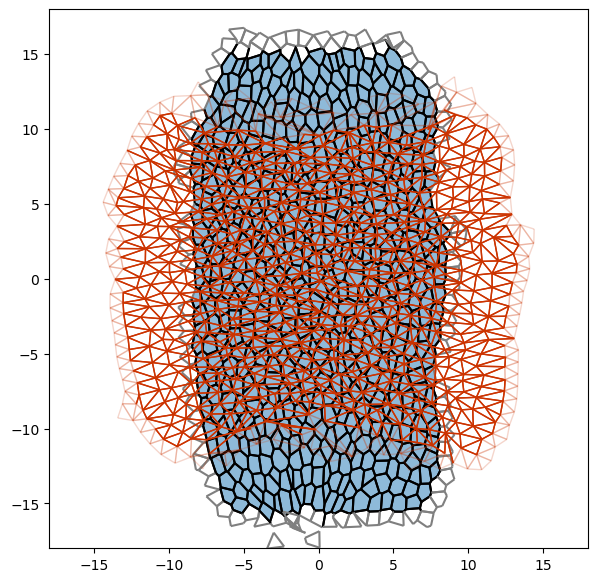

In [ ]:
t = 120

fig, ax = plt.subplots(figsize=(7, 7))
meshes[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

meshes[t].triplot_color(edge_colors=edge_colors_tri)

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

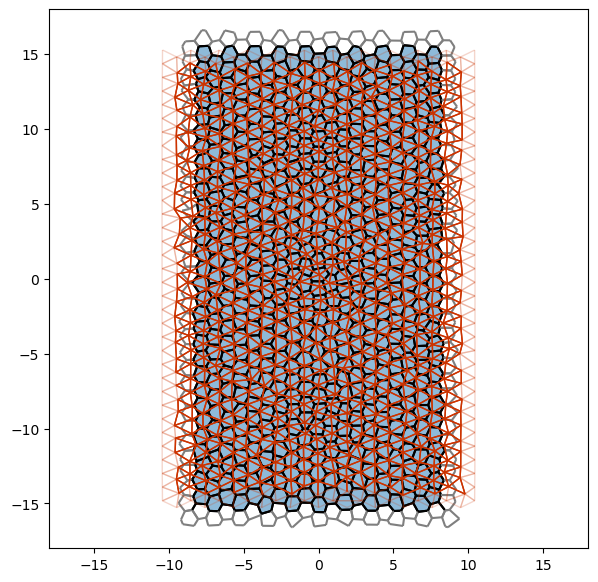

In [ ]:
t = 1

fig, ax = plt.subplots(figsize=(7, 7))
meshes[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

meshes[t].triplot_color(edge_colors=edge_colors_tri)

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

### Extension vs time

In [ ]:
w_passive = 8
rel_angle_penalty = 0.995
rep = 1
key1 = (w_passive, rel_angle_penalty, rep)

w_passive = 8
rel_angle_penalty = 0.995
rep = 2
key2 = (w_passive, rel_angle_penalty, rep)

w_passive = 7
rel_angle_penalty = 0.995
rep = 1
key3 = (w_passive, rel_angle_penalty, rep)

w_passive = 7
rel_angle_penalty = 0.995
rep = 2
key4 = (w_passive, rel_angle_penalty, rep)

<matplotlib.legend.Legend>

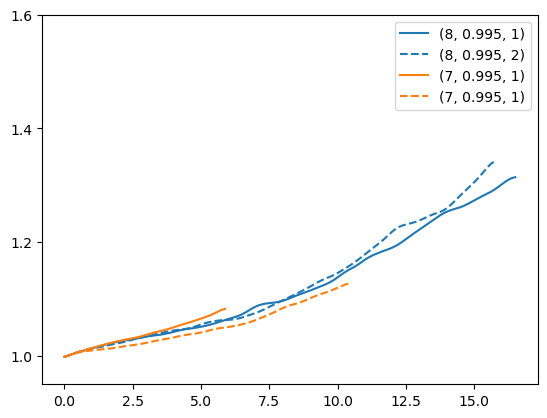

In [ ]:
strain = 0.2
k_relax = 2
k_cutoff = 0.3

plt.plot(time[:elongation_dict[key1].shape[0]], elongation_dict[key1], label=f"{key1}", color="tab:blue")
plt.plot(time[:elongation_dict[key2].shape[0]], elongation_dict[key2], label=f"{key2}", color="tab:blue", ls="dashed")

plt.plot(time[:elongation_dict[key3].shape[0]], elongation_dict[key3], label=f"{key3}", color="tab:orange")
plt.plot(time[:elongation_dict[key4].shape[0]], elongation_dict[key4], label=f"{key3}", color="tab:orange", ls="dashed")

plt.yticks([1.0, 1.2, 1.4, 1.6])
plt.ylim([0.95, 1.6])
plt.legend()

### Loading some existing simulations

In [ ]:
sim_dir = "/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_WT_TollRM9"

In [ ]:
meshes = [iso.CellHalfEdgeMesh.load_mesh(f"{sim_dir}/w_passive_1.5_randomSeed_3/{str(i).zfill(4)}_mesh") for i in tqdm(range(150))]
with open(f"{sim_dir}/w_passive_1.5_randomSeed_3/property_dict.pickle", "rb") as f:
    property_dict = pickle.load(f)


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
edge_colors = {e: "tab:grey" for e in property_dict['passive_edges']}
cell_colors = {v: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
               for v in meshes[1].vertices.keys() if not v in property_dict['passive_cells']}
edge_colors_tri = {e: np.array([0.8, 0.2, 0, .2]) if e in property_dict['passive_edges']
                   or any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                   for e, he in meshes[0].hes.items()}


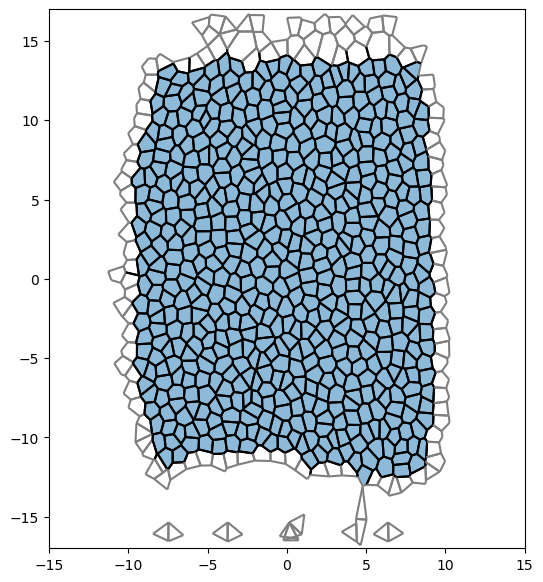

In [ ]:
t = 80

fig, ax = plt.subplots(figsize=(7, 7))
meshes[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

#meshes[t].triplot_color(edge_colors=edge_colors_tri)

ax.set_xlim([-bdry_x, bdry_x])
ax.set_ylim([-bdry_y, bdry_y])
ax.set_aspect("equal", adjustable="box")

In [ ]:
orientations = ["parallel", "orthogonal"]
k_relaxs = [2, 1/4, 1/20] # 
k_passives = [4, 6, 12]
noise_gaussians = [0.05, 0.1, 0.15]
noise_dynamics = [0, 0.2]
feedbacks = ["perimeter", "area"]
use_voronois = [False, True]
k_cutoffs = [0.2, 0.3, 0.4] # 0.2 we alreay have from last simulation 

reps = np.array([1, 2, 3]) # number of replicates # 1, 2, 3

# k_relax and k passive dependence
to_do = list(itertools.product(orientations, k_relaxs, k_passives, [0.1,], ["perimeter",], [0,], [False,], [0.3,], reps))
# gaussian noise influence
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.05, 0.15], ["perimeter",], [0,], [False,], [0.3,], reps))
# area vs perimeter
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["area",], [0,], [False,], [0.3,], reps))
# noise in tension dynamics
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["perimeter",], [0.2,], [False,], [0.3,], reps))
# Voronoi simulations
to_do = to_do + list(itertools.product(orientations, [2,], [6,], [0.1,], ["perimeter",], [0,], [True,], [0.3,], reps))
# cutoff dependence
to_do = to_do + list(itertools.product(orientations, [2], [6], [0.1,], ["perimeter",], [0,], [False,], [0.2, 0.4], reps))


In [ ]:
len(to_do)

96

In [ ]:
96/24

4.0